Exploring Socioeconmic Features
===============================

This notebook explores various socioeconomic features in the Titanic dataset, such as Pclass, Title and Fare. Preliminary investigation of the dataset indicate thart these three features have a strong impact on survivability.

In [45]:
# set up code and dataframe with training data
import pandas as pd
import matplotlib.pyplot as plt

import sklearn.metrics as ms
import sklearn.model_selection as mds
import sklearn.tree as tr

datestamp = "20250218.143352"
df_ = pd.read_csv(f"../data/kaggle/train.clean.{datestamp}.csv")
print(df_.shape)

(891, 35)


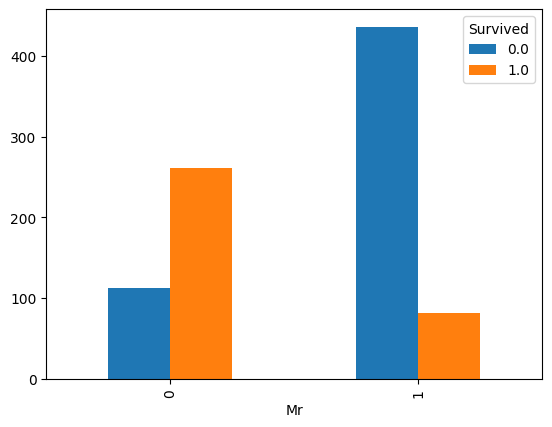

In [46]:
# set up the X, y values for the train and test sets
x_colname = 'Mr'
y_colname = 'Survived'

# transform the dataframe, so that it can be properly graphed as a bar plot
df_group_count = df_.groupby([x_colname, y_colname])[x_colname].count()
df_misters_grouped = df_group_count.unstack(y_colname)
df_misters_grouped.plot(kind='bar')
plt.show()

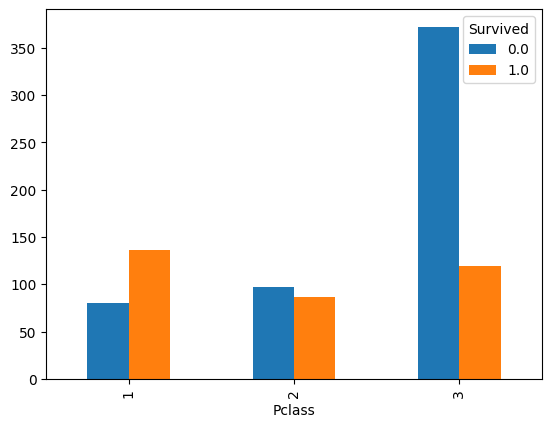

In [47]:
# set up the X, y values for the train and test sets
x_colname = 'Pclass'
y_colname = 'Survived'

# transform the dataframe, so that it can be properly graphed as a bar plot
df_group_count = df_.groupby([x_colname, y_colname])[x_colname].count()
df_pclass_grouped = df_group_count.unstack(y_colname)
df_pclass_grouped.plot(kind='bar')
plt.show()

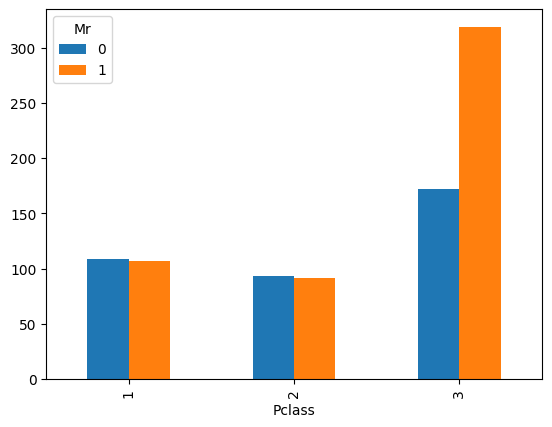

In [48]:
# set up the X, y values for the train and test sets
x_colname = 'Pclass'
y_colname = 'Mr'

# transform the dataframe, so that it can be properly graphed as a bar plot
df_group_count = df_.groupby([x_colname, y_colname])[x_colname].count()
df_pclass_grouped = df_group_count.unstack(y_colname)
df_pclass_grouped.plot(kind='bar')
plt.show()

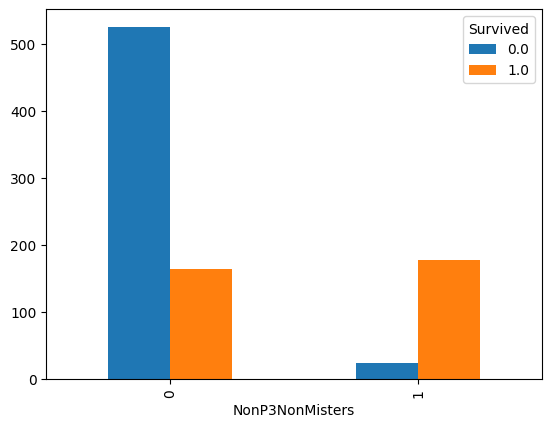

In [49]:
df_["NonP3NonMisters"] = df_.apply( lambda k: 1 if ((k.Mr == 0) and (k.Pclass < 3)) else 0, axis=1 )

# set up the X, y values for the train and test sets
x_colname = 'NonP3NonMisters'
y_colname = 'Survived'

# transform the dataframe, so that it can be properly graphed as a bar plot
df_group_count = df_.groupby([x_colname, y_colname])[x_colname].count()
df_pclass_grouped = df_group_count.unstack(y_colname)
df_pclass_grouped.plot(kind='bar')
plt.show()

# Create a Subset

The graph above shows us that we can see a STRONG correlation by folks that survived, and the folks that didn't have the title "Mr" (not poor) and were rated Pclass 1 or Pclass 2. To do another round of analysis, let's take a subset of the "P3 / Misters" group (the first blue bar). And then run that through a decision tree.

In [50]:
#df_subset = df_[ df_["NonP3NonMisters"] == 0 ]

x_colnames = [ 'Mr', 'Pclass3', 'GroupSize', 'OtherMale', 'OtherFemale' ]

X = df_[ x_colnames]
y = df_[ 'Survived' ].values

# Assuming you have your features in X and your target variable in y
X_train, X_test, y_train, y_test = mds.train_test_split(X, y, test_size=0.5, random_state=42)

n_folds = 6
s_scoring = "balanced_accuracy"

param_dist = {
    'max_leaf_nodes': [ 7  ],
    'max_depth': [ 5  ],
    'min_samples_split': [ 25, 50, 75, 100 ],
    'min_samples_leaf': [ 10, 20, 30, 40, 50 ]
} 

# Create a decision tree classifier
clf = tr.DecisionTreeClassifier(criterion='gini', random_state=42)

grid_search = mds.GridSearchCV( estimator=clf,
                                param_grid=param_dist,
                                cv=n_folds,
                                scoring=s_scoring,
                                n_jobs=-1 )

# Train the classifier
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
model       = grid_search.best_estimator_

print(best_params)
print()

{'max_depth': 5, 'max_leaf_nodes': 7, 'min_samples_leaf': 10, 'min_samples_split': 50}



In [51]:
importances = model.feature_importances_
feature_imp_df = pd.DataFrame(
    {'Feature': x_colnames, 'Gini Importance': importances} ).sort_values(
         'Gini Importance', ascending=False)
print(feature_imp_df)

       Feature  Gini Importance
0           Mr         0.675960
1      Pclass3         0.212181
2    GroupSize         0.111859
3    OtherMale         0.000000
4  OtherFemale         0.000000


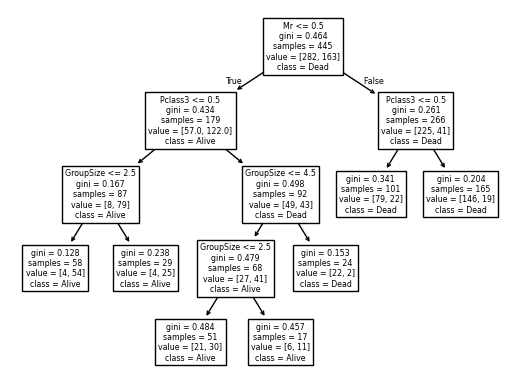

In [52]:
tr.plot_tree(model, feature_names=x_colnames, class_names=['Dead', 'Alive'])
plt.show()

In [53]:
threshold_tuner = mds.TunedThresholdClassifierCV(
    clf, scoring=s_scoring, cv=n_folds).fit(X_train, y_train)
threshold = threshold_tuner.best_threshold_

print(f"Threshold {round(threshold,3)} gives score: {round(threshold_tuner.best_score_,2)}")
print()


Threshold 0.293 gives score: 0.8



In [54]:
y_test_preds_proba = model.predict_proba(X_test)
y_test_preds = (y_test_preds_proba[:,1] > threshold).astype(int)

tn, fp, fn, tp = ms.confusion_matrix(y_test, y_test_preds).ravel()
print(f"Confusion Matrix, at Threshold {threshold:.3f}")
print(f"  tn {tn:<3}  fp {fp:<3}")
print(f"  fn {fn:<3}  tp {tp:<3}")
print()

bal_acc   = round( ms.balanced_accuracy_score( y_test, y_test_preds ), 3 )
precision = round( ms.precision_score( y_test, y_test_preds ), 3 )
recall    = round( ms.recall_score( y_test, y_test_preds ), 3 )
f1        = round( ms.f1_score( y_test, y_test_preds, average='micro' ), 3 )

s_scores = f"Bal Acc: {bal_acc}, Pre: {precision}, Rec: {recall}, F1 Micro: {f1}"
print(s_scores)

Confusion Matrix, at Threshold 0.293
  tn 230  fp 37 
  fn 42   tp 137

Bal Acc: 0.813, Pre: 0.787, Rec: 0.765, F1 Micro: 0.823


In [55]:
df_test = pd.read_csv(f"../data/kaggle/test.clean.{datestamp}.csv")

df_test["NonP3NonMisters"] = df_test.apply( lambda k: 1 if ((k.Mr == 0) and (k.Pclass < 3)) else 0, axis=1 )

y_proba = model.predict_proba(df_test[x_colnames])
y_preds = (y_proba[:,1] > threshold).astype(int)

df_test["SurvivedProbability"] = y_proba[:,1]
df_test["Survived"] = y_preds

df_sub = df_test[ (df_test[ "GroupSize" ] > 4) ]

df_sub[["Pclass", "Name", "Sex", "GroupSize", "AgeImputed", "AgeRobust", "FppRobust", "SurvivedProbability", "Survived"]].head(15)

df_test[["PassengerId", "Survived"]].to_csv(f"../data/kaggle/submit.socioeconomic.csv", index=False)